# Checking the rigorous RWA: population dynamics and spectra

In [1]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt

import UD_liouv as RC
import driving_liouv as EM
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar

import spectra_functions as SF

reload(RC)
reload(EM)
reload(exact)
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

# Things that will always be true
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 5.309
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = J_multipolar#EM.J_minimal

w_RC=990.0 | TLS splitting = 1000.0 | RC-res. coupling=0.02 | TLS-RC coupling=557.69 | Gamma_RC=100.00 | alpha_ph=200.00 | N=12 |
Calculating non-RWA Liouvilliian took 0.574522972107 seconds.
It took  1.02565598488  seconds to build the Non-secular RWA Liouvillian
It took  1.55930399895  seconds to build the vibronic Lindblad Liouvillian
10.0%. Run time:   0.57s. Est. time left: 00:00:00:05
20.0%. Run time:   1.11s. Est. time left: 00:00:00:04
30.0%. Run time:   1.67s. Est. time left: 00:00:00:03
40.0%. Run time:   2.24s. Est. time left: 00:00:00:03
50.0%. Run time:   2.81s. Est. time left: 00:00:00:02
60.0%. Run time:   3.38s. Est. time left: 00:00:00:02
70.0%. Run time:   3.94s. Est. time left: 00:00:00:01
80.0%. Run time:   4.52s. Est. time left: 00:00:00:01
90.0%. Run time:   5.08s. Est. time left: 00:00:00:00
Total run time:   5.66s
10.0%. Run time:   0.30s. Est. time left: 00:00:00:02
20.0%. Run time:   0.63s. Est. time left: 00:00:00:02
30.0%. Run time:   0.94s. Est. time left: 

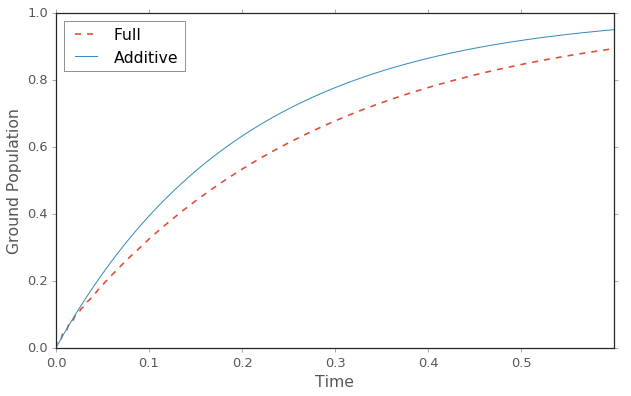

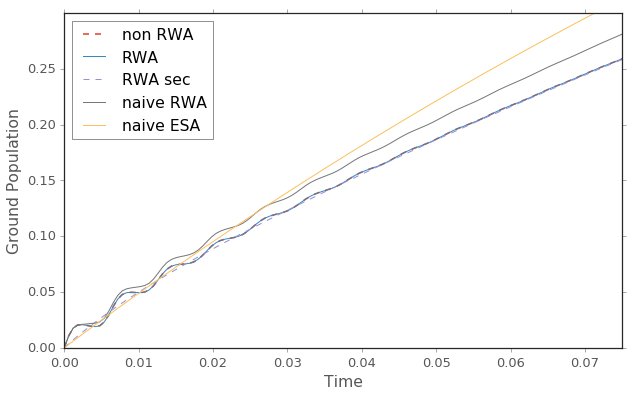

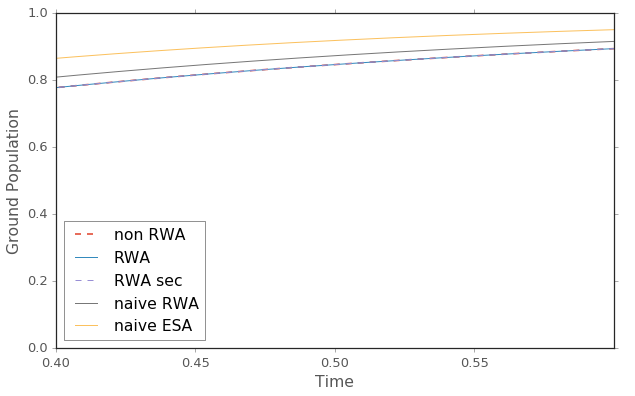

w_RC=50.0 | TLS splitting = 1000.0 | RC-res. coupling=0.32 | TLS-RC coupling=125.33 | Gamma_RC=100.00 | alpha_ph=200.00 | N=27 |
Calculating non-RWA Liouvilliian took 2.9906771183 seconds.
It took  4.41952013969  seconds to build the Non-secular RWA Liouvillian
It took  14.2946670055  seconds to build the vibronic Lindblad Liouvillian
10.0%. Run time:   8.09s. Est. time left: 00:00:01:12
20.0%. Run time:  15.39s. Est. time left: 00:00:01:01
30.0%. Run time:  22.44s. Est. time left: 00:00:00:52
40.0%. Run time:  29.50s. Est. time left: 00:00:00:44
50.0%. Run time:  36.64s. Est. time left: 00:00:00:36
60.0%. Run time:  43.78s. Est. time left: 00:00:00:29
70.0%. Run time:  51.14s. Est. time left: 00:00:00:21
80.0%. Run time:  58.71s. Est. time left: 00:00:00:14
90.0%. Run time:  66.42s. Est. time left: 00:00:00:07
Total run time:  74.05s
10.0%. Run time:   6.06s. Est. time left: 00:00:00:54
20.0%. Run time:  11.79s. Est. time left: 00:00:00:47
30.0%. Run time:  17.23s. Est. time left: 00:

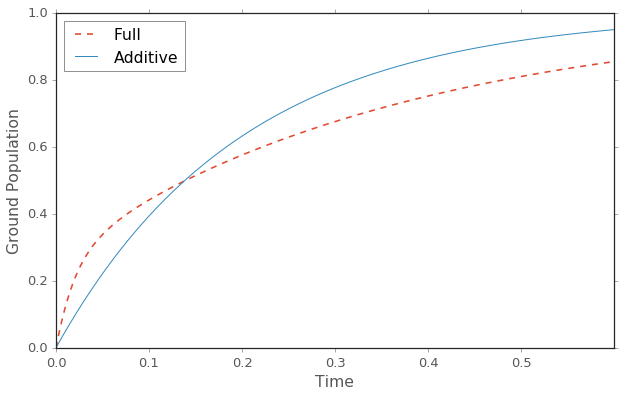

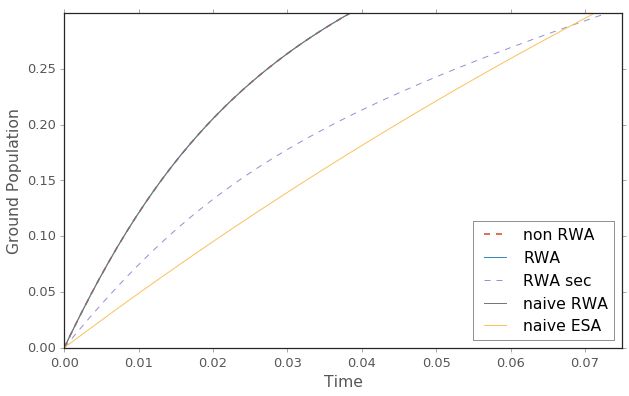

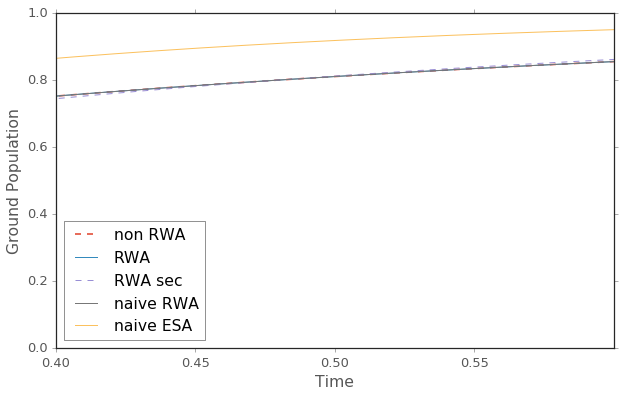

In [4]:
nTimeSteps = 1000
timelist = np.linspace(0, 0.60, nTimeSteps)

def dynamics_plotter(eps=1000., T_ph=300., w0_prop=0.1, alpha_prop=0.1, 
                     Gamma_prop=0.1, T_EM=0., Gamma_EM_prop=0.005, N = 25):
    
    Gamma, w0, alpha_ph, Gamma_EM = Gamma_prop*eps, w0_prop*eps, alpha_prop*eps, Gamma_EM_prop*eps
    L_RC, H_RC, A_EM, A_nrwa, _, _, _, _ = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, N)

    #S_plus, S_minus, S_0 = EM.RWA_system_ops(H_RC, A_nrwa)
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM)
    """
    L_vib_ns = EM.L_nonsecular(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM).tidyup(atol=1E-9)
    L_vib_s = EM.L_vib_lindblad(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM).tidyup(atol=1E-9)
    L_em_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True).tidyup(atol=1E-9)
    L_em_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True).tidyup(atol=1E-9)
    """
    L_em = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
    expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
                   tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
                   tensor(qeye(2), destroy(N).dag()+destroy(N))]
    n_RC = EM.Occupation(w0, T_ph)
    rho_0 = tensor(E*E.dag(), thermal_dm(N, n_RC))
    #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
    #print H_RC.eigenenergies()
    #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
    """DATA_rig = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_ns], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[0].real"""
    DATA_nrwa = mesolve(H_RC, rho_0, timelist, [L_RC+L_nrwa], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[0].real
    """
    DATA_rigsec = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_s], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    DATA_nonrig = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_ns], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real"""
    DATA_ESA = mesolve(H_RC, rho_0, timelist, [L_RC+L_em], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    #DATA_nonrig_sec = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_s], 
    #                      expects, options=qt.Options(nsteps=1000)).expect[0].real
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='Full', ls='dashed', linewidth=1.6)
    #plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    #plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    #plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='Additive')
    plt.xlim(timelist[0], timelist[-1])
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    plt.ylim(0.,0.3)
    plt.xlim(0.,0.075)
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    #
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.xlim(timelist[-1]-0.2,timelist[-1])
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    plt.show()
    
dynamics_plotter(alpha_prop=0.2, w0_prop=0.99, N=12)
dynamics_plotter(alpha_prop=0.2, w0_prop=0.05, N=27)

20.0

## TODO: Rate differences between Full, RWA and non-rigorous RWA


## Emission Spectra

1.0


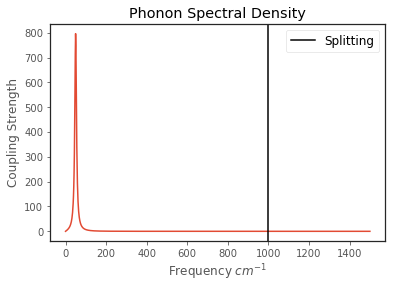

w_RC=50.0 | TLS splitting = 1000 | RC-res. coupling=0.03 | TLS-RC coupling=111.80 | Gamma_RC=10.00 | alpha_ph=159.15 | N=25 |
Completed initial dynamics calculations for Naive in 54.3776431084 seconds.
Completed correlation function calculations for Naive in 6.09229898453 seconds.
Completed initial dynamics calculations for Full in 96.1332731247 seconds.
Completed correlation function calculations for Full in 8.9848139286 seconds.


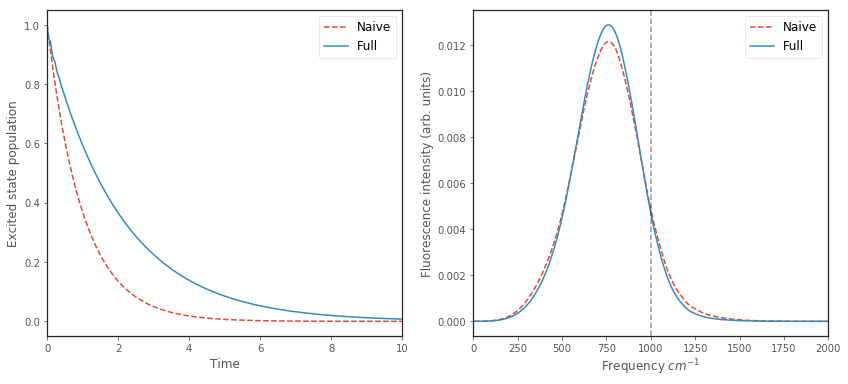

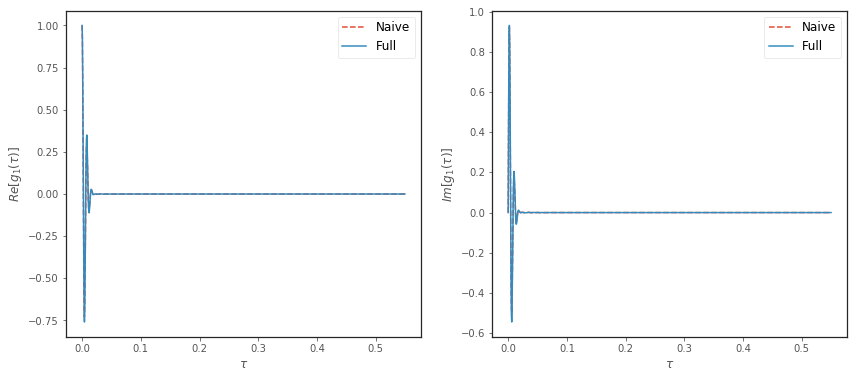

In [31]:

reload(SF)
alpha_prop = 0.5
w0_prop = 0.05
eps = 1000
Gamma = eps*0.01
Gamma_EM = eps*0.001
print Gamma_EM
# beginning in a product state of |E> and non-displaced thermal state (that's what the first parameters mean)
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=77., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=25)


### Emission: Lower $T_{ph}$

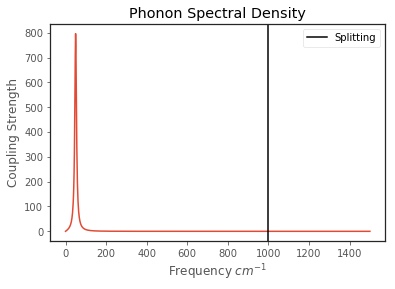

w_RC=50.0 | TLS splitting = 1000 | RC-res. coupling=0.03 | TLS-RC coupling=111.80 | Gamma_RC=10.00 | alpha_ph=159.15 | N=25 |
Completed initial dynamics calculations for Naive in 42.2892541885 seconds.
Completed correlation function calculations for Naive in 8.21822595596 seconds.
Completed initial dynamics calculations for Full in 58.1104929447 seconds.
Completed correlation function calculations for Full in 10.4670469761 seconds.


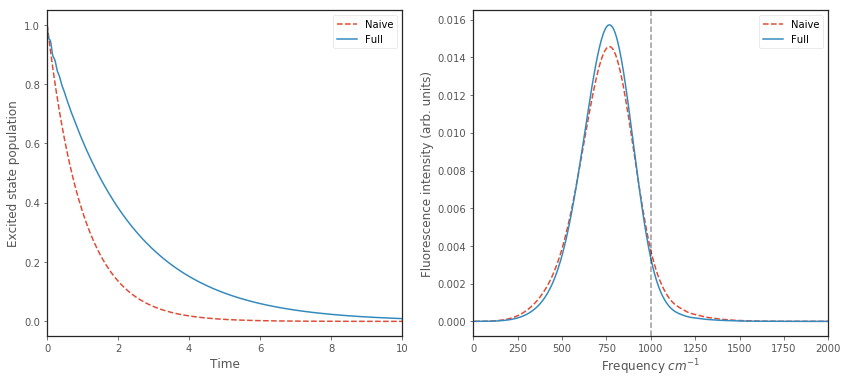

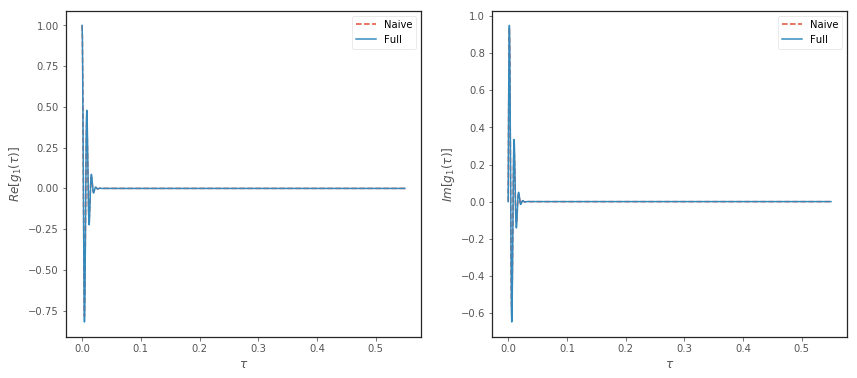

In [28]:
alpha_prop = 0.5
w0_prop = 0.05
eps = 1000
Gamma = eps*0.01
Gamma_EM = eps*0.001
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=45., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=25)

### Emission: smaller $\omega_0$ but larger $\alpha_1$

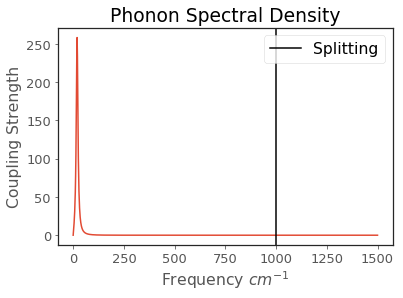

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=63.25 | Gamma_RC=10.00 | alpha_ph=127.32 | N=27 |
Completed initial dynamics calculations for Naive in 107.552579165 seconds.
Completed correlation function calculations for Naive in 6.44572305679 seconds.
Completed initial dynamics calculations for Full in 119.561945915 seconds.
Completed correlation function calculations for Full in 12.9050130844 seconds.


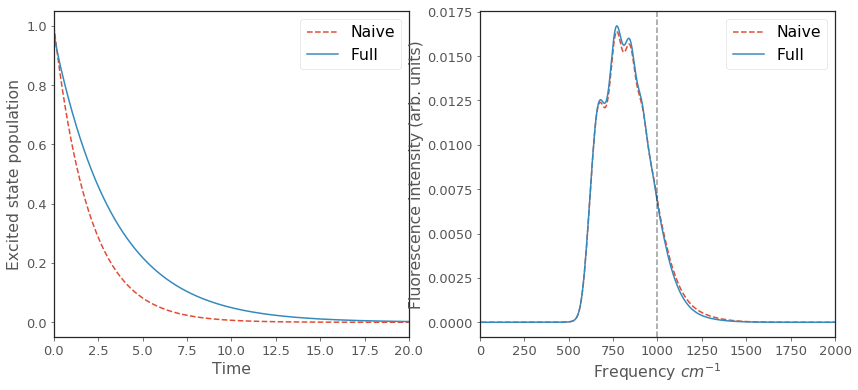

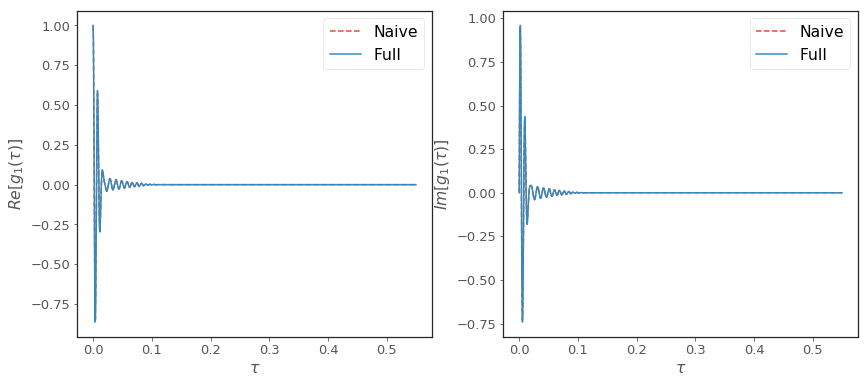

In [38]:
alpha_prop = 0.4
w0_prop = 0.02
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

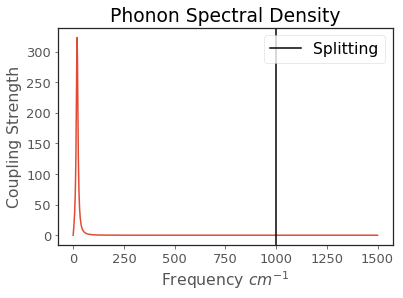

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=70.71 | Gamma_RC=10.00 | alpha_ph=159.15 | N=27 |
Completed initial dynamics calculations for Naive in 108.050420046 seconds.
Completed correlation function calculations for Naive in 11.4769351482 seconds.
Completed initial dynamics calculations for Full in 119.560393095 seconds.
Completed correlation function calculations for Full in 12.3575100899 seconds.


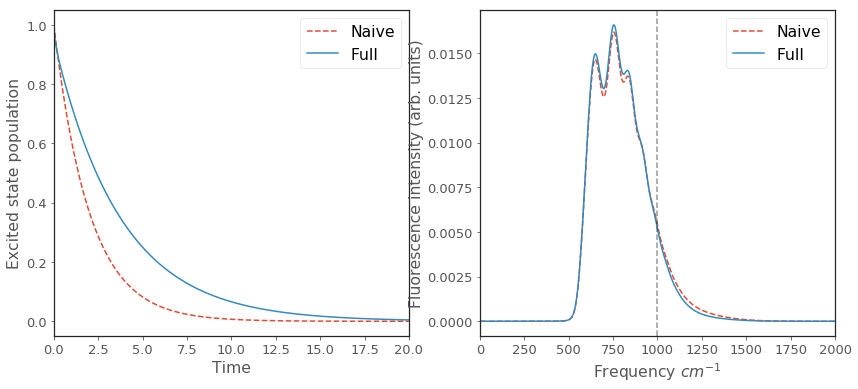

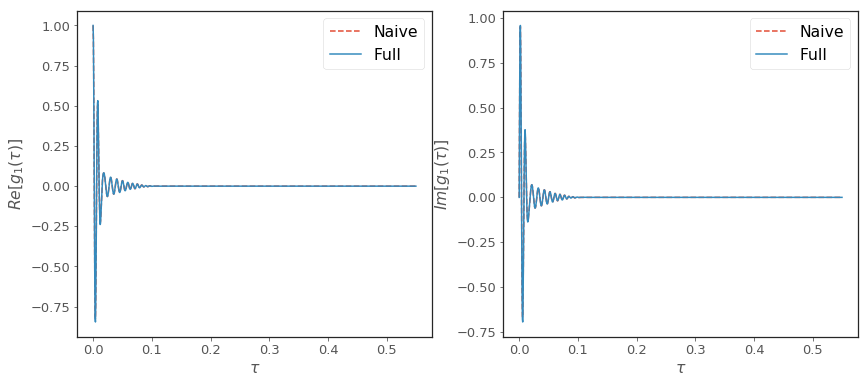

In [40]:
alpha_prop = 0.5
w0_prop = 0.02
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

The last calculations are slightly more interesting...

### Emission: smaller spontaneous emission and phonon broadening

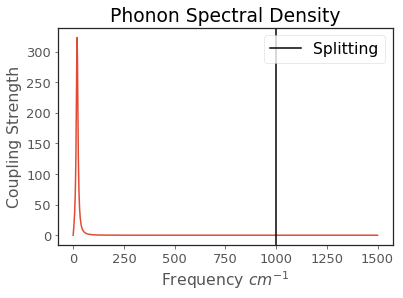

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=70.71 | Gamma_RC=10.00 | alpha_ph=159.15 | N=27 |
Completed initial dynamics calculations for Naive in 103.544978142 seconds.
Completed correlation function calculations for Naive in 9.60875701904 seconds.
Completed initial dynamics calculations for Full in 115.829185963 seconds.
Completed correlation function calculations for Full in 14.7421360016 seconds.


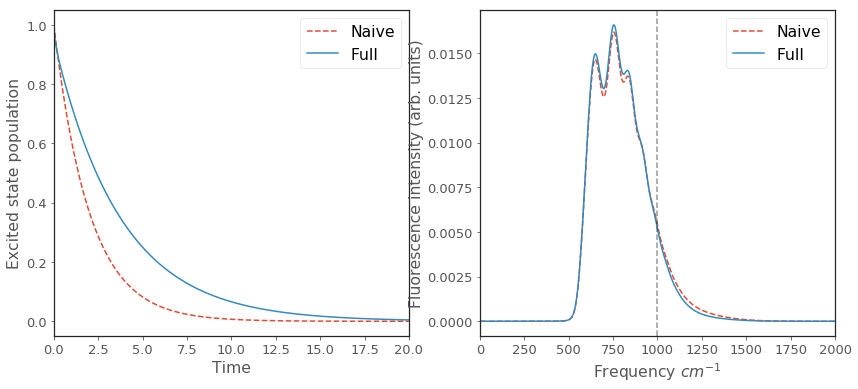

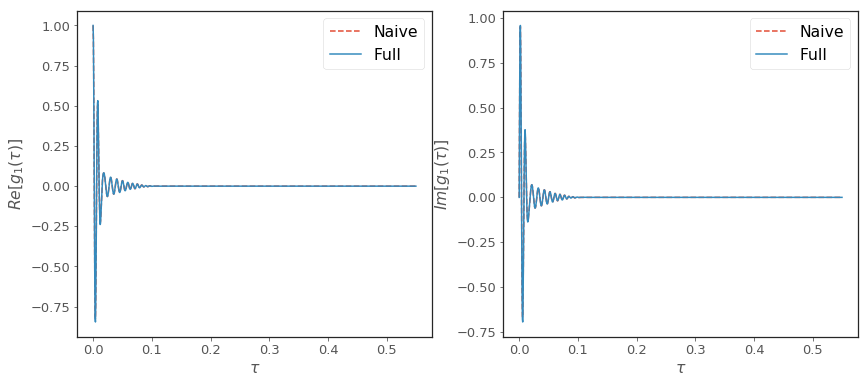

In [42]:
alpha_prop = 0.5
w0_prop = 0.02
eps = 1000
Gamma = eps*0.01
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

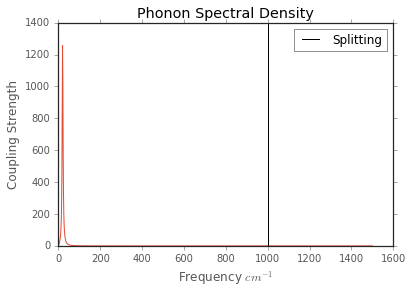

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.04 | TLS-RC coupling=100.00 | Gamma_RC=5.00 | alpha_ph=318.31 | N=27 |
Completed initial dynamics calculations for Naive in 84.2470109463 seconds.
Completed correlation function calculations for Naive in 8.75793814659 seconds.
Completed initial dynamics calculations for Full in 93.8188679218 seconds.
Completed correlation function calculations for Full in 10.8651258945 seconds.


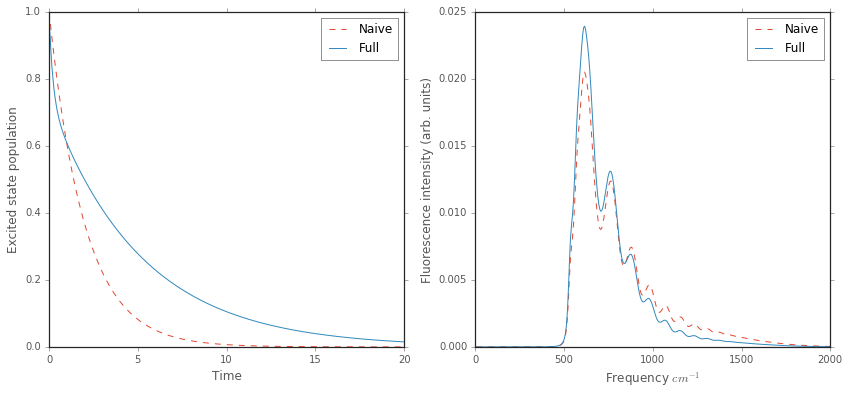

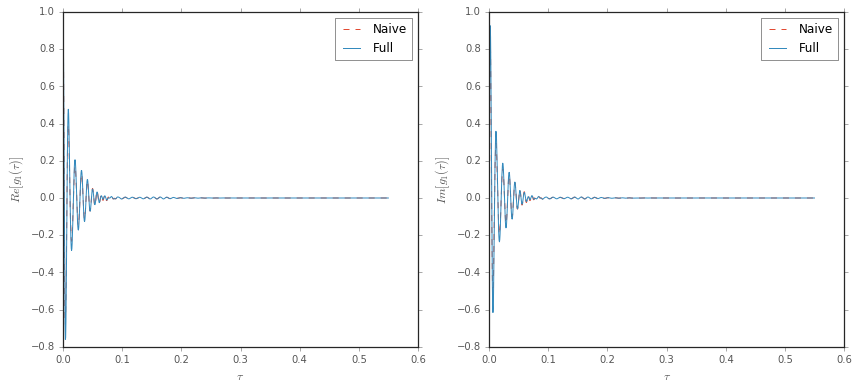

In [2]:
reload(SF)
alpha_prop = 1.
w0_prop = 0.02
eps = 1000
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

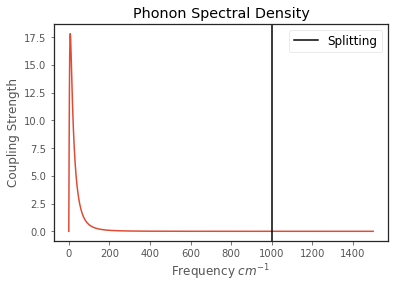

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.48 | TLS-RC coupling=31.62 | Gamma_RC=60.49 | alpha_ph=31.83 | N=27 |
Completed initial dynamics calculations for Naive in 51.9058740139 seconds.
Completed correlation function calculations for Naive in 31.7289760113 seconds.
Completed initial dynamics calculations for Full in 50.1810450554 seconds.
Completed correlation function calculations for Full in 38.7844150066 seconds.


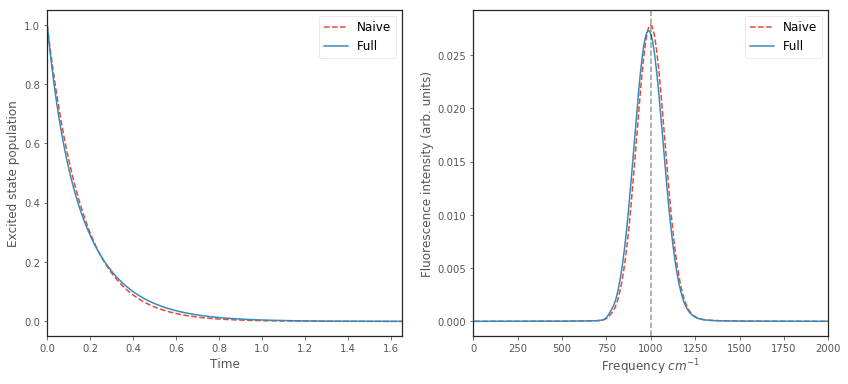

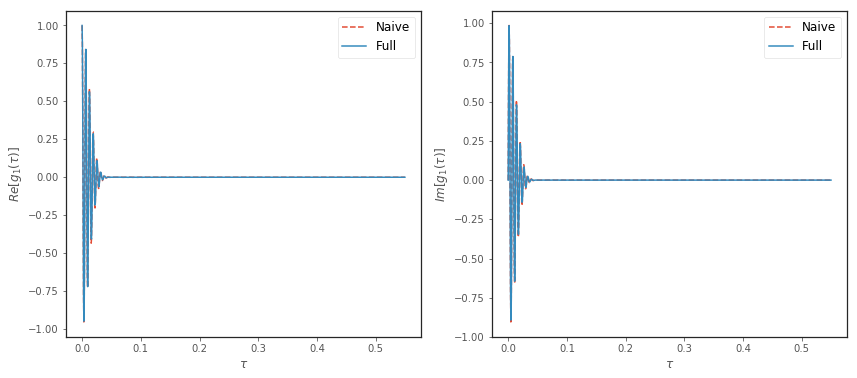

In [18]:
alpha_prop = 0.1
w0_prop = 0.02
eps = ev_to_inv_cm*1.5
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

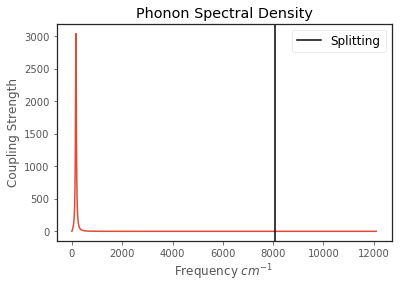

w_RC=161.31 | TLS splitting = 8065.5 | RC-res. coupling=0.04 | TLS-RC coupling=441.77 | Gamma_RC=40.33 | alpha_ph=770.20 | N=27 |
Completed initial dynamics calculations for Naive in 57.0613410473 seconds.
Completed correlation function calculations for Naive in 5.72468781471 seconds.
Completed initial dynamics calculations for Full in 65.8397397995 seconds.
Completed correlation function calculations for Full in 6.07505011559 seconds.


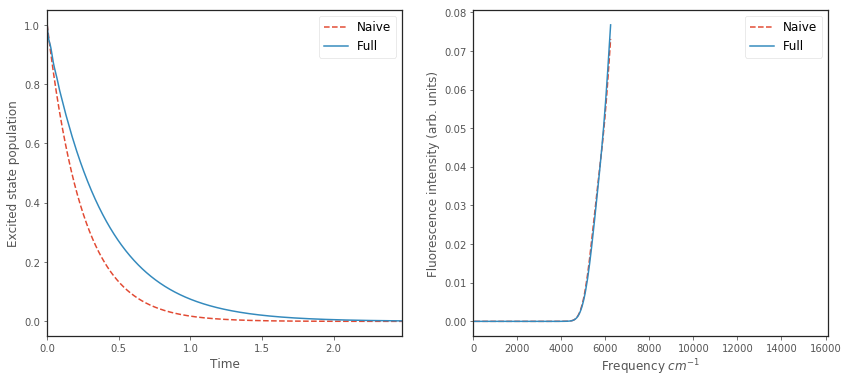

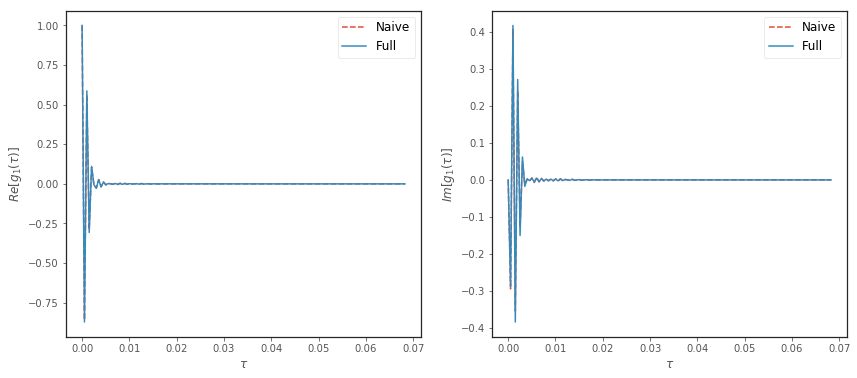

In [6]:
reload(SF)
alpha_prop = 0.3
w0_prop = 0.02
eps = ev_to_inv_cm*1.
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27, tau_f_mult=0.125)

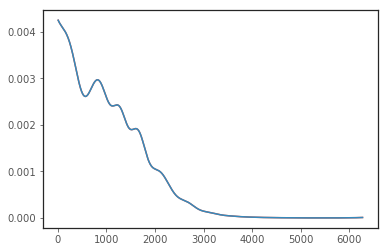

In [26]:
plt.plot(freq, spec)
plt.show()

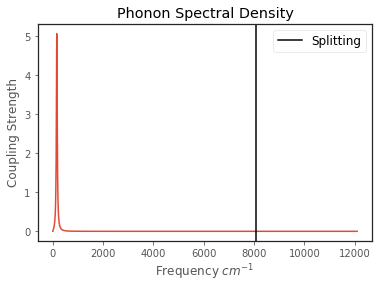

w_RC=161.31 | TLS splitting = 8065.5 | RC-res. coupling=0.04 | TLS-RC coupling=18.04 | Gamma_RC=40.33 | alpha_ph=1.28 | N=10 |
Completed initial dynamics calculations for Naive in 0.956996917725 seconds.
Completed correlation function calculations for Naive in 3.2286939621 seconds.
Completed initial dynamics calculations for Full in 1.13579297066 seconds.
Completed correlation function calculations for Full in 3.52195096016 seconds.


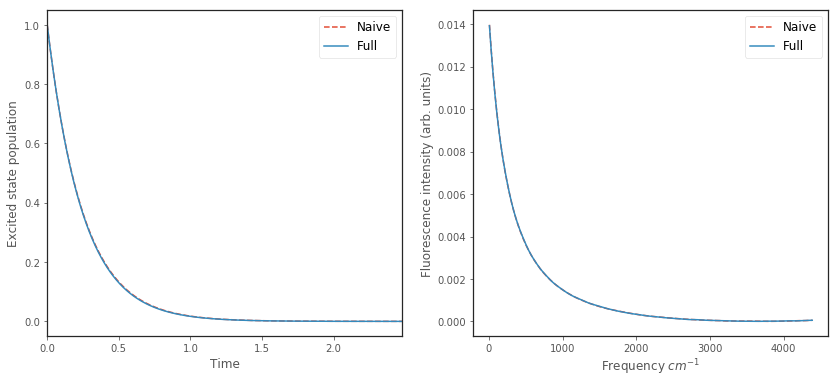

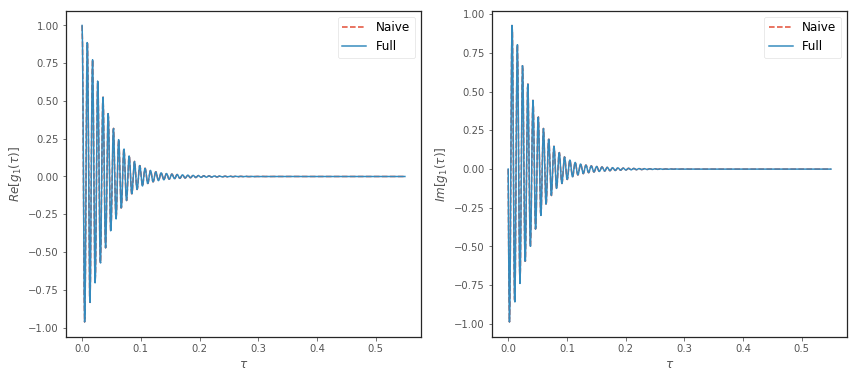

In [25]:

reload(SF)
alpha_prop = 0.0005
w0_prop = 0.02
eps = ev_to_inv_cm*1.
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=10, tau_f_mult=1., per_tau=0.7)

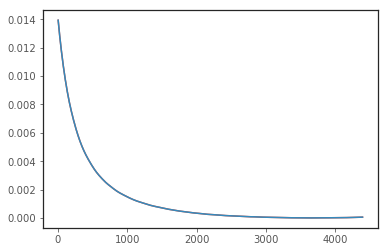

In [27]:
plt.plot(freq, spec)
plt.show()

## Emission: much higher $\omega_0$

note that $g_1(\tau)$ is calculated for twice as long as is shown on the axes. I expect that the spectra will agree much more in this parameter regime.

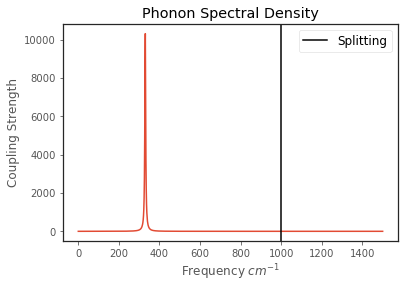

w_RC=330.0 | TLS splitting = 1000 | RC-res. coupling=0.00 | TLS-RC coupling=287.23 | Gamma_RC=5.00 | alpha_ph=159.15 | N=14 |
Completed initial dynamics calculations for Naive in 39.5174250603 seconds.
Completed correlation function calculations for Naive in 10.9831750393 seconds.
Completed initial dynamics calculations for Full in 59.4871919155 seconds.
Completed correlation function calculations for Full in 18.0676279068 seconds.


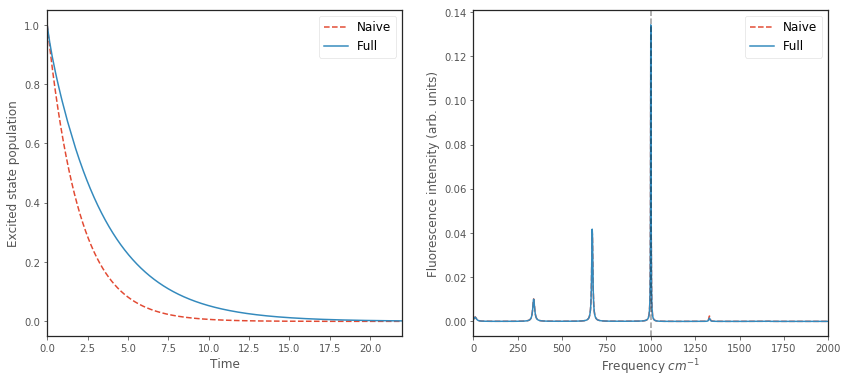

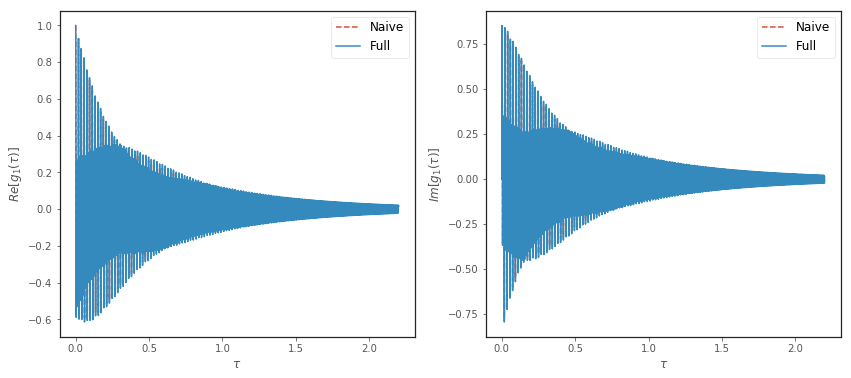

In [14]:
reload(SF)
alpha_prop = 0.5
w0_prop = 0.33
eps = 1000
Gamma = eps*0.005
Gamma_EM = eps*0.0005


freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=14, end_T_mult=11, tau_f_mult=4.)

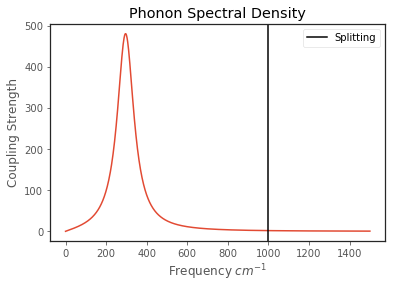

w_RC=300.0 | TLS splitting = 1000 | RC-res. coupling=0.05 | TLS-RC coupling=273.86 | Gamma_RC=100.00 | alpha_ph=159.15 | N=12 |
Completed initial dynamics calculations for Naive in 11.1509330273 seconds.
Completed correlation function calculations for Naive in 1.65879893303 seconds.
Completed initial dynamics calculations for Full in 15.4421069622 seconds.
Completed correlation function calculations for Full in 1.92984294891 seconds.


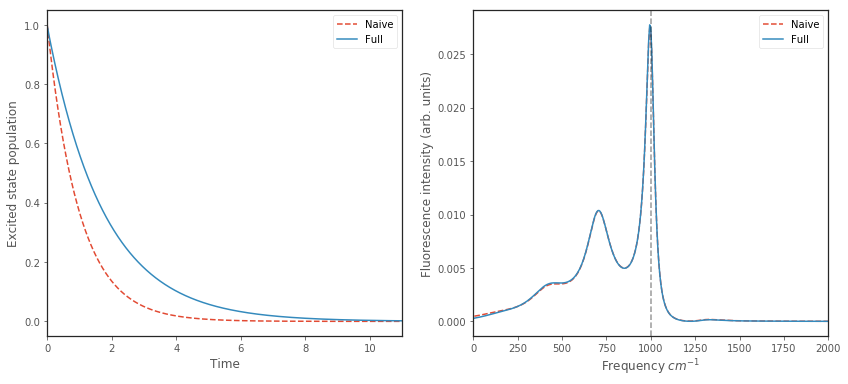

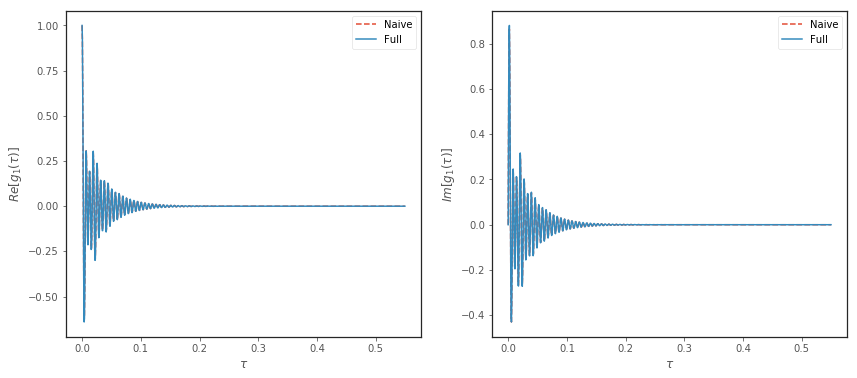

In [25]:
reload(SF)
alpha_prop = 0.5
w0_prop = 0.3
Gamma = eps*0.1
Gamma_EM = eps*0.001
eps = 1000

freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=12, end_T_mult=11)

## Absorption spectra
This remains to be done. I need to look over the calculation again but it's not really on my agenda right now...

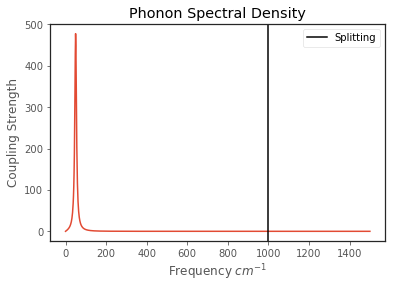

w_RC=50.0 | TLS splitting = 1000 | RC-res. coupling=0.03 | TLS-RC coupling=86.60 | Gamma_RC=10.00 | alpha_ph=95.49 | N=15 |
Completed response function calculations for Naive in 2.42631196976 seconds.
Completed response function calculations for Full in 2.37483692169 seconds.


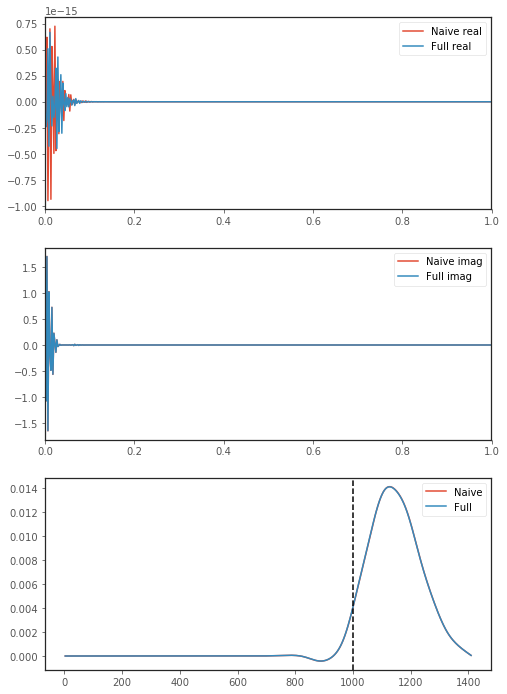

In [36]:
reload(SF)
alpha_prop = 0.3
w0_prop = 0.05
eps = 1000
Gamma = eps*0.01
Gamma_EM = eps*0.001
freq, spec = SF.absorption_spectra(alpha_prop, eps, Gamma, w0_prop*eps, Gamma_EM=Gamma_EM, overdamped=False, N=15)